In [150]:
import json
import requests
import os
import zipfile
import geopandas as gpd 
import pandas as pd
import contextily as cx
import numpy as np
import io
from pandas import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns

# 0) Integración de datos

In [151]:
#Leer censo
cpv_path = r'CPV_2020\ageb_mza_urbana_19_cpv2020\conjunto_de_datos\conjunto_de_datos_ageb_urbana_19_cpv2020.csv'
cpv = pd.read_csv(cpv_path)

#Leer DENUE
denue_path = r'denue_19_shp\conjunto_de_datos\denue_inegi_19_.shp'
denue = gpd.read_file(denue_path)

# 1) Comprensión y exploración de los datos del negocio

## CENSO

El df del Censo de población y vivienda del INEGI incluye más de 200 columnas y contiene registros de cada manzana de Nuevo León. Para este analisis se utilizaran unicamente algunas columnas relacionadas con la **demografía de la población** en cuanto a edad, escolaridad y acceso a salud, así como columnas relacionadas con el tipo de **viviendas** y sus características. Estas  fueron seleccionadas basandonos en los indicadores que utiliza la CONEVAL en ciertas bases de datos para evaluar el resago social. Así mismo se filtro para tener unicamente registros de los municipios del **Area Metropolitana de Monterrey**.

In [152]:
# columnas seleccionadas
col =['MUN',
 'NOM_MUN',
 'AGEB',
 'POBTOT',
 'VIVPAR_HAB',
 'P18YM_PB',
 'PSINDER',
 'VPH_EXCSA',
 'VPH_LAVAD',
 'VPH_REFRI',
 'VPH_TELEF',
 'P15YM_AN',
 'P6A11_NOAM',
 'P12A14NOA',
 'VPH_PISOTI',
 'VPH_NDEAED']

cpv_fil = cpv.loc[:,col]

#filtrar por clave de  municipios (['Monterrey','San NicolÃ¡s de los Garza','Guadalupe','Apodaca','JuÃ¡rez','Santa Catarina','General Escobedo','San Pedro Garza GarcÃ\xada']

mun_c = [39,46,26,6,31,48,21,19]
cpv_fil= cpv_fil[cpv_fil['MUN'].isin(mun_c)]

#agrego una columna de identificación compuesta por el número de MUNICIPIO y AGEB
cpv_fil['CVEMA'] = cpv_fil['MUN'].map(str).str.zfill(3) + cpv_fil['AGEB'].map(str).str.zfill(4)


In [153]:
cpv_fil.NOM_MUN.unique()

array(['Apodaca', 'San Pedro Garza García', 'General Escobedo',
       'Guadalupe', 'Juárez', 'Monterrey', 'San Nicolás de los Garza',
       'Santa Catarina'], dtype=object)

In [154]:
#a) Dimensión del dataset. Indica cantidad de registros y columnas
cpv_fil.shape

(52565, 17)

In [155]:
cpv_fil.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52565 entries, 2105 to 78437
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   MUN         52565 non-null  int64 
 1   NOM_MUN     52565 non-null  object
 2   AGEB        52565 non-null  object
 3   POBTOT      52565 non-null  int64 
 4   VIVPAR_HAB  52565 non-null  object
 5   P18YM_PB    52565 non-null  object
 6   PSINDER     52565 non-null  object
 7   VPH_EXCSA   52565 non-null  object
 8   VPH_LAVAD   52565 non-null  object
 9   VPH_REFRI   52565 non-null  object
 10  VPH_TELEF   52565 non-null  object
 11  P15YM_AN    52565 non-null  object
 12  P6A11_NOAM  52565 non-null  object
 13  P12A14NOA   52565 non-null  object
 14  VPH_PISOTI  52565 non-null  object
 15  VPH_NDEAED  52565 non-null  object
 16  CVEMA       52565 non-null  object
dtypes: int64(2), object(15)
memory usage: 7.2+ MB


1. **MUN (int64)**: Cualitativa. Código numérico del municipio.
   
2. **NOM_MUN (object)**: Cualitativa. Nombre del municipio.

3. **AGEB (object)**: Cualitativa. Código de la Área Geoestadística Básica.

4. **POBTOT (int64)**: Cuantitativa. Población total.

5. **VIVPAR_HAB (int64)**: Cuantitativa. Número de viviendas particulares habitadas.

6. **P18YM_PB (int64)**: Cuantitativa. Población de 18 años o más con primaria completa.

7. **PSINDER (int64)**: Cuantitativa. Población sin derechohabiencia a servicios de salud.

8. **VPH_EXCSA (int64)**: Cuantitativa. Viviendas particulares con excusado o sanitario.

9. **VPH_LAVAD (int64)**: Cuantitativa. Viviendas particulares con lavadora.

10. **VPH_REFRI (int64)**: Cuantitativa. Viviendas particulares con refrigerador.

11. **VPH_TELEF (int64)**: Cuantitativa. Viviendas particulares con teléfono fijo.

12. **P15YM_AN (int64)**: Cuantitativa. Población de 15 años o más analfabeta.

13. **P6A11_NOAM (int64)**: Cuantitativa. Población de 6 a 11 años sin asistencia escolar.

14. **P12A14NOA (int64)**: Cuantitativa. Población de 12 a 14 años que no asiste a la escuela.

15. **VPH_PISOTI (int64)**: Cuantitativa. Viviendas particulares con piso de tierra.

16. **VPH_NDEAED (int64)**: Cuantitativa. Viviendas particulares habitadas que disponen de agua entubada en el ámbito de la vivienda.

17. **CVEMA (object)**: Cualitativa. Clave compuesta por Municipio y AGEB.



In [156]:
#valores nullos
cpv_fil.isnull().sum()

MUN           0
NOM_MUN       0
AGEB          0
POBTOT        0
VIVPAR_HAB    0
P18YM_PB      0
PSINDER       0
VPH_EXCSA     0
VPH_LAVAD     0
VPH_REFRI     0
VPH_TELEF     0
P15YM_AN      0
P6A11_NOAM    0
P12A14NOA     0
VPH_PISOTI    0
VPH_NDEAED    0
CVEMA         0
dtype: int64

Se sabe que en la base de datos existen valores censorados que aparecen como **' * '** además existen algunos datos **'N/D'**.Para que estos datos no causen problemas se sustituiran por _0_

In [157]:
cpv_fil.replace('*', 0, inplace = True)
cpv_fil.replace('N/D', 0, inplace = True)

La siguientes columnas son aquellas que contienen datos del tipo entero pero al cargar la base de datos se guardaton como object. Por lo tanto se cambiaran al tipo int.

In [158]:
#columnas a cambiar
pob = ['POBTOT',
 'VIVPAR_HAB',
 'P18YM_PB',
 'PSINDER',
 'VPH_EXCSA',
 'VPH_LAVAD',
 'VPH_REFRI',
 'VPH_TELEF',
 'P15YM_AN',
 'P6A11_NOAM',
 'P12A14NOA',
 'VPH_PISOTI',
 'VPH_NDEAED']

cpv_fil[pob] = cpv_fil[pob].astype(int)

In [159]:
cpv_fil.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52565 entries, 2105 to 78437
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   MUN         52565 non-null  int64 
 1   NOM_MUN     52565 non-null  object
 2   AGEB        52565 non-null  object
 3   POBTOT      52565 non-null  int32 
 4   VIVPAR_HAB  52565 non-null  int32 
 5   P18YM_PB    52565 non-null  int32 
 6   PSINDER     52565 non-null  int32 
 7   VPH_EXCSA   52565 non-null  int32 
 8   VPH_LAVAD   52565 non-null  int32 
 9   VPH_REFRI   52565 non-null  int32 
 10  VPH_TELEF   52565 non-null  int32 
 11  P15YM_AN    52565 non-null  int32 
 12  P6A11_NOAM  52565 non-null  int32 
 13  P12A14NOA   52565 non-null  int32 
 14  VPH_PISOTI  52565 non-null  int32 
 15  VPH_NDEAED  52565 non-null  int32 
 16  CVEMA       52565 non-null  object
dtypes: int32(13), int64(1), object(3)
memory usage: 4.6+ MB


Para este proyecto se busca segmentar por AGEBS, por lo tanto se agruparan las manzanas de un mismo AGEB y se sumaran sus valores, creando un nuevo data frame que contenga registros de cada AGEB de Nuevo León en vez de Manzanas

In [160]:
pivot=pd.pivot_table(cpv_fil,index=['CVEMA','MUN', 'NOM_MUN', 'AGEB'],values=pob,aggfunc=['sum'])

In [161]:
pivot

sum                               \
                                P12A14NOA P15YM_AN P18YM_PB P6A11_NOAM   
CVEMA   MUN NOM_MUN        AGEB                                          
0060000 6   Apodaca        0000      2993     7125   550134       2171   
0060013 6   Apodaca        0013         0        0        0          0   
0060032 6   Apodaca        0032         0        0      175          0   
0060047 6   Apodaca        0047         0        0     1962          0   
0060051 6   Apodaca        0051        17       38     1290         17   
...                                   ...      ...      ...        ...   
0481647 48  Santa Catarina 1647         0        0      890          0   
0481651 48  Santa Catarina 1651         4        0      560          0   
0481666 48  Santa Catarina 1666         0        0       13          0   
0481685 48  Santa Catarina 1685         0        0        0          0   
0481702 48  Santa Catarina 1702         0        0        0          0   

                                                                       \
                                  POBTOT PSINDER VIVPAR_HAB VPH_EXCSA   
CVEMA   MUN NOM_MUN        AGEB                                         
0060000 6   Apodaca        0000  1303078  205545     347966    359894   
0060013 6   Apodaca        0013        0       0          0         0   
0060032 6   Apodaca        0032      292      21         89        93   
0060047 6   Apodaca        0047     3438     344       1042      1150   
0060051 6   Apodaca        0051     4488     559       1256      1300   
...                                  ...     ...        ...       ...   
0481647 48  Santa Catarina 1647     2592     330        696       720   
0481651 48  Santa Catarina 1651     1070      74        218       236   
0481666 48  Santa Catarina 1666      134      13         28        28   
0481685 48  Santa Catarina 1685        0       0          0         0   
0481702 48  Santa Catarina 1702        0       0          0         0   

                                                                           \
                                VPH_LAVAD VPH_NDEAED VPH_PISOTI VPH_REFRI   
CVEMA   MUN NOM_MUN        AGEB                                             
0060000 6   Apodaca        0000    330962         13       1276    354977   
0060013 6   Apodaca        0013         0          0          0         0   
0060032 6   Apodaca        0032        85          0          0        91   
0060047 6   Apodaca        0047      1039          0          0      1142   
0060051 6   Apodaca        0051      1166          0          0      1278   
...                                   ...        ...        ...       ...   
0481647 48  Santa Catarina 1647       630          0          0       716   
0481651 48  Santa Catarina 1651       236          0          0       236   
0481666 48  Santa Catarina 1666        21          0          0        22   
0481685 48  Santa Catarina 1685         0          0          0         0   
0481702 48  Santa Catarina 1702         0          0          0         0   

                                           
                                VPH_TELEF  
CVEMA   MUN NOM_MUN        AGEB            
0060000 6   Apodaca        0000    227230  
0060013 6   Apodaca        0013         0  
0060032 6   Apodaca        0032         0  
0060047 6   Apodaca        0047       632  
0060051 6   Apodaca        0051       774  
...                                   ...  
0481647 48  Santa Catarina 1647         0  
0481651 48  Santa Catarina 1651       216  
0481666 48  Santa Catarina 1666         0  
0481685 48  Santa Catarina 1685         0  
0481702 48  Santa Catarina 1702         0  

[1645 rows x 13 columns]

In [162]:
#exporto pivot y hago ajustes en hoja de calculos de excel
#pivot.to_csv('censo_pivot.csv')

#La tabla pivote se exporto como .csv y se modifico su esteuctura en una hoja de calculo. Se renombro como "censo_final.csv" y se vuelve a leer

In [163]:
censo = pd.read_csv('censo_final.csv')
censo.head()

,CVEMA,MUN,NOM_MUN,AGEB,P12A14NOA,P15YM_AN,P18YM_PB,P6A11_NOAM,POBTOT,PSINDER,VIVPAR_HAB,VPH_EXCSA,VPH_LAVAD,VPH_NDEAED,VPH_PISOTI,VPH_REFRI,VPH_TELEF
0,0060000,6,Apodaca,0000,2993,7125,550134,2171,1303078,205545,347966,359894,330962,13,1276,354977,227230
1,0060013,6,Apodaca,0013,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0060032,6,Apodaca,0032,0,0,175,0,292,21,89,93,85,0,0,91,0
3,0060047,6,Apodaca,0047,0,0,1962,0,3438,344,1042,1150,1039,0,0,1142,632
4,0060051,6,Apodaca,0051,17,38,1290,17,4488,559,1256,1300,1166,0,0,1278,774


In [164]:
censo['MUN'] = censo['MUN'].astype(object)

In [165]:
censo.to_csv('censo_FIN.csv')

In [166]:
censo.shape

(1645, 17)

### EDA 

1) **Calcula medidas estadísticas**

   **Variables cuantitativas**

   - **Medidas de tendencia central:** Promedio, media, mediana y moda de los datos.
   - **Medidas de dispersión:** Rango (máximo - mínimo), varianza, desviación estándar.

   **Variables cualitativas o categóricas**

   - Tabla de distribución de frecuencia.
   - Moda.

2) **Explora los datos usando herramientas de visualización**

   **Variables cuantitativas:**

   - Medidas de posición no-central: Cuartiles, valores atípicos (outliers), boxplots.
   - Análisis de distribución de los datos (Histogramas). Identificar si tienen forma simétrica o asimétrica.
   - Análisis de correlación de los datos, mapa de calor.

   **Variables cualitativas o categóricas:**

   - Distribución de los datos (Diagramas de barras, diagramas de pastel).
   - Encontrar relaciones entre variables, principalmente con lo que se quiere predecir, para ver cómo se comporta. Pueden crear tablas de contingencia usando la función de pandas `crosstab` o también usar la función chi-cuadrado.

**Material de apoyo:**
[Measure the correlation between numerical and categorical variables and the correlation between two categorical variables in Python: Chi-square and ANOVA](http://www.sefidian.com/2022/08/02/measure-the-correlation-between-numerical-and-categorical-variables-and-the-correlation-between-two-categorical-variables-in-python-chi-square-and-anova/)


In [167]:
censo.describe()

,P12A14NOA,P15YM_AN,P18YM_PB,P6A11_NOAM,POBTOT,PSINDER,VIVPAR_HAB,VPH_EXCSA,VPH_LAVAD,VPH_NDEAED,VPH_PISOTI,VPH_REFRI,VPH_TELEF
count,1645.000000,1645.000000,1.645000e+03,1645.000000,1.645000e+03,1645.000000,1645.000000,1645.000000,1645.000000,1645.000000,1645.000000,1645.000000,1645.000000
mean,22.421884,89.478419,4.261238e+03,15.054711,1.027080e+04,1918.936778,2696.091185,2885.543465,2600.084498,0.152584,15.993921,2827.564134,1862.483283
std,235.178502,884.356736,3.543405e+04,163.411336,8.316953e+04,15939.169666,21776.202445,23464.475690,21168.920173,2.708541,171.573500,22997.950012,15579.403293
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,3.000000,9.250000e+02,0.000000,2.430000e+03,310.000000,639.000000,704.000000,636.000000,0.000000,0.000000,689.000000,390.000000
50%,5.000000,14.000000,1.840000e+03,3.000000,5.096000e+03,813.000000,1348.000000,1461.000000,1318.000000,0.000000,0.000000,1436.000000,896.000000
75%,11.000000,46.000000,3.094000e+03,7.000000,7.414000e+03,1419.000000,1908.000000,2046.000000,1834.000000,0.000000,6.000000,2010.000000,1343.000000
max,6578.000000,28134.000000,1.019099e+06,4884.000000,2.285946e+06,450013.000000,579832.000000,650341.000000,586635.000000,96.000000,5226.000000,637308.000000,454930.000000


In [168]:
censo.describe(include='O')

,CVEMA,MUN,NOM_MUN,AGEB
count,1645,1645,1645,1645
unique,1645,8,8,1395
top,0060000,39,Monterrey,0000
freq,1,492,492,8


In [214]:
censo_por_AGEB = censo.drop(censo[censo['AGEB']=='0000'].index)
censo_por_AGEB

,CVEMA,MUN,NOM_MUN,AGEB,P12A14NOA,P15YM_AN,P18YM_PB,P6A11_NOAM,POBTOT,PSINDER,VIVPAR_HAB,VPH_EXCSA,VPH_LAVAD,VPH_NDEAED,VPH_PISOTI,VPH_REFRI,VPH_TELEF
1,0060013,6,Apodaca,0013,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0060032,6,Apodaca,0032,0,0,175,0,292,21,89,93,85,0,0,91,0
3,0060047,6,Apodaca,0047,0,0,1962,0,3438,344,1042,1150,1039,0,0,1142,632
4,0060051,6,Apodaca,0051,17,38,1290,17,4488,559,1256,1300,1166,0,0,1278,774
5,0060066,6,Apodaca,0066,4,6,493,6,1388,131,407,435,404,0,4,423,315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1640,0481647,48,Santa Catarina,1647,0,0,890,0,2592,330,696,720,630,0,0,716,0
1641,0481651,48,Santa Catarina,1651,4,0,560,0,1070,74,218,236,236,0,0,236,216
1642,0481666,48,Santa Catarina,1666,0,0,13,0,134,13,28,28,21,0,0,22,0
1643,0481685,48,Santa Catarina,1685,0,0,0,0,0,0,0,0,0,0,0,0,0


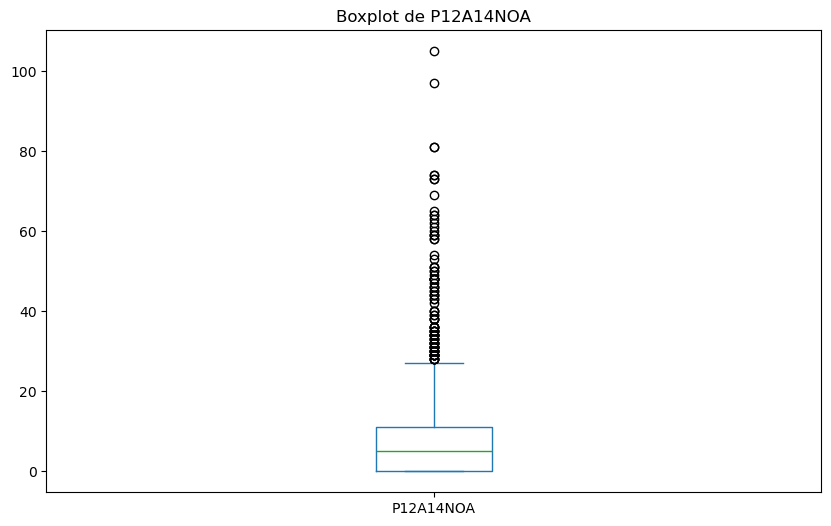

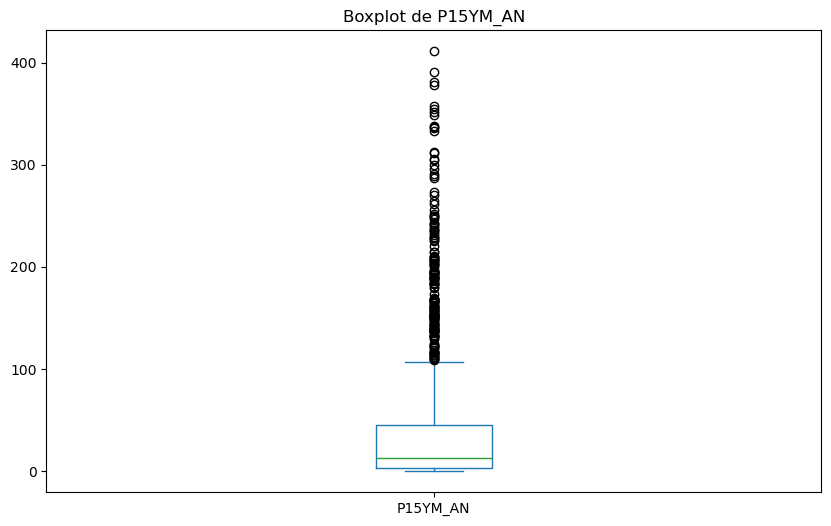

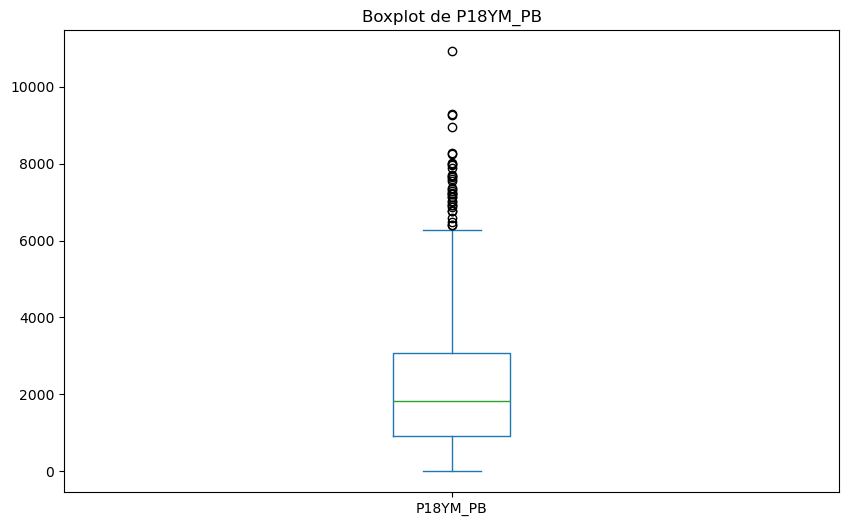

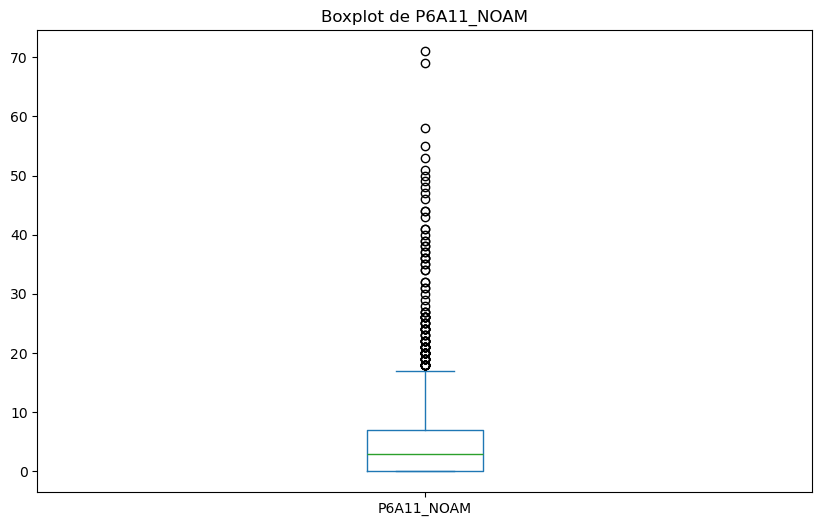

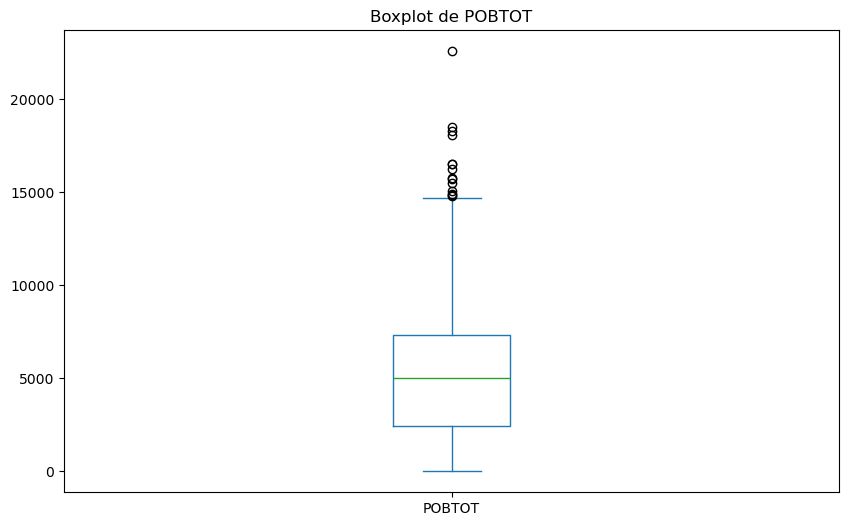

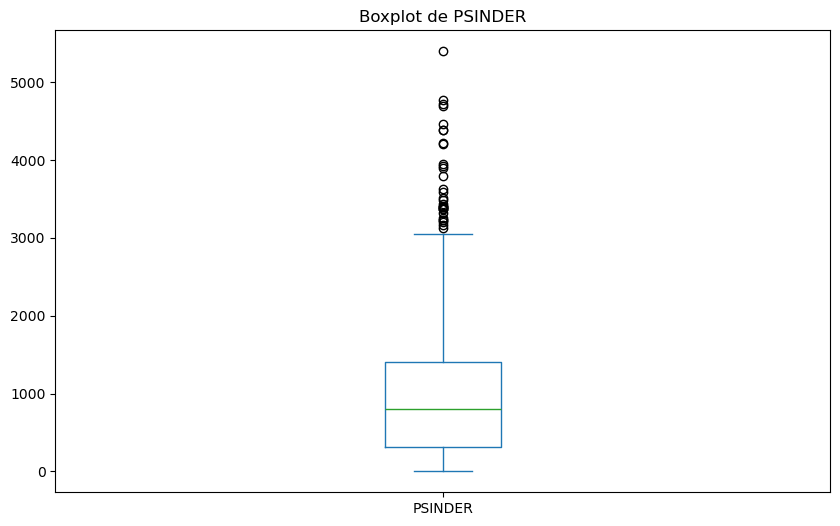

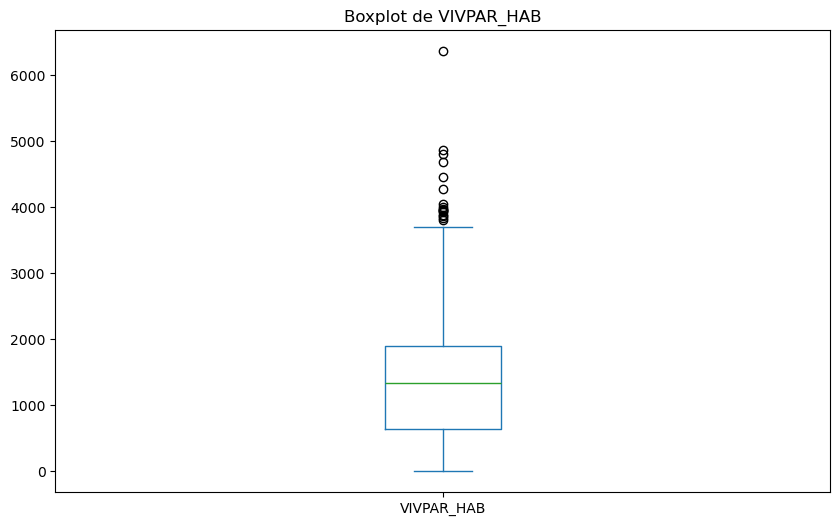

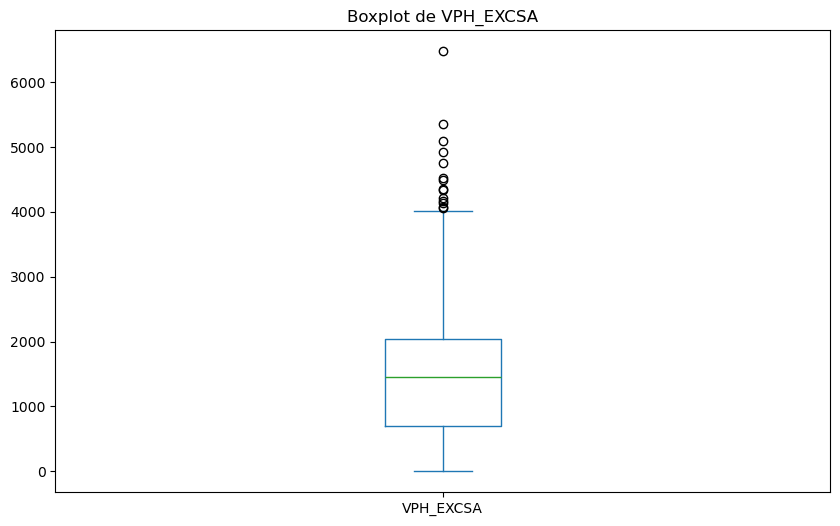

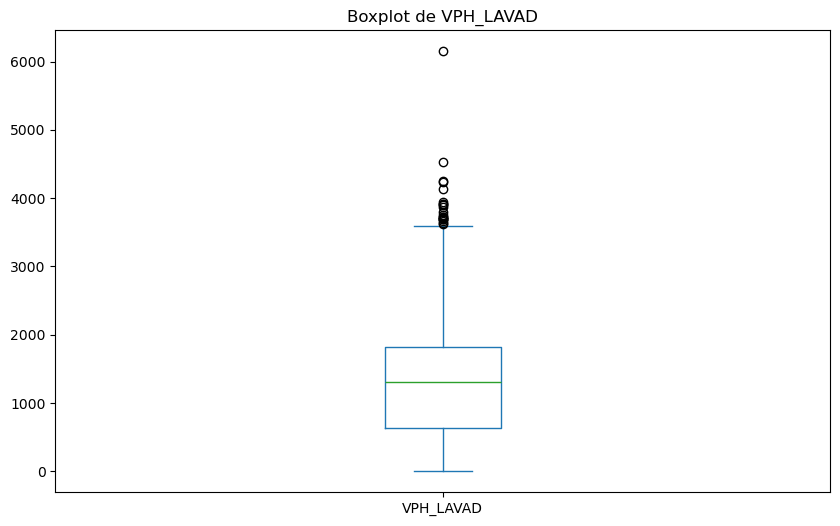

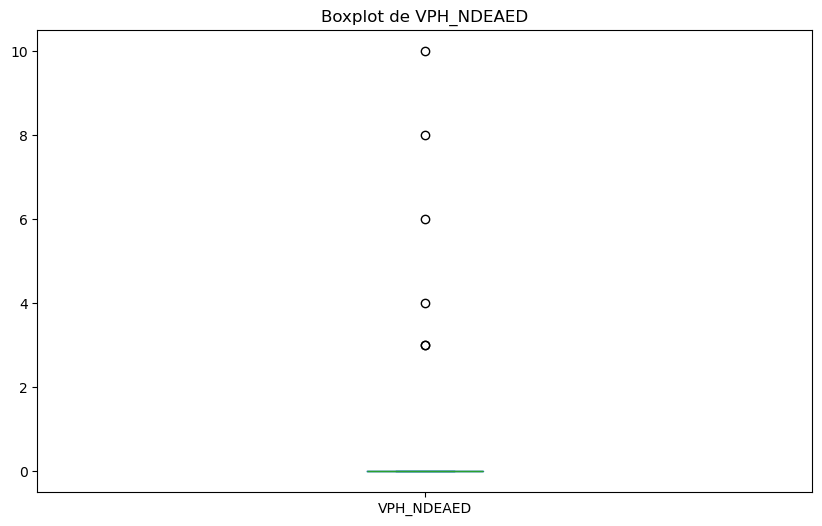

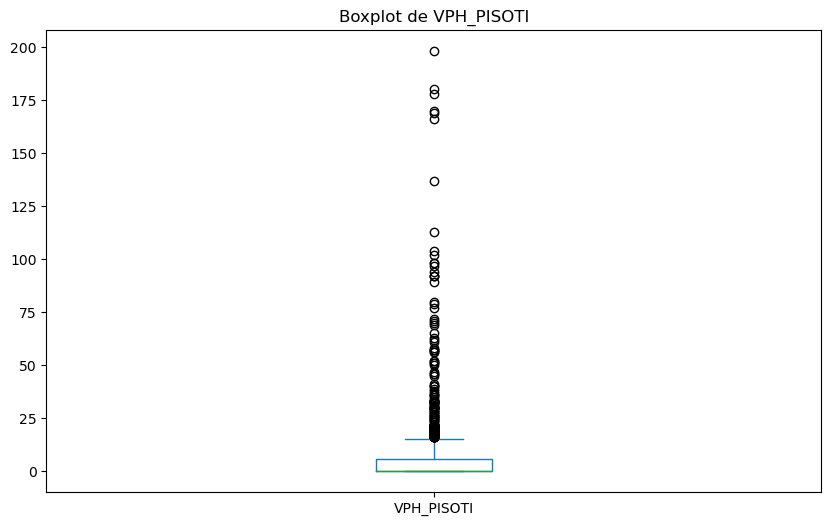

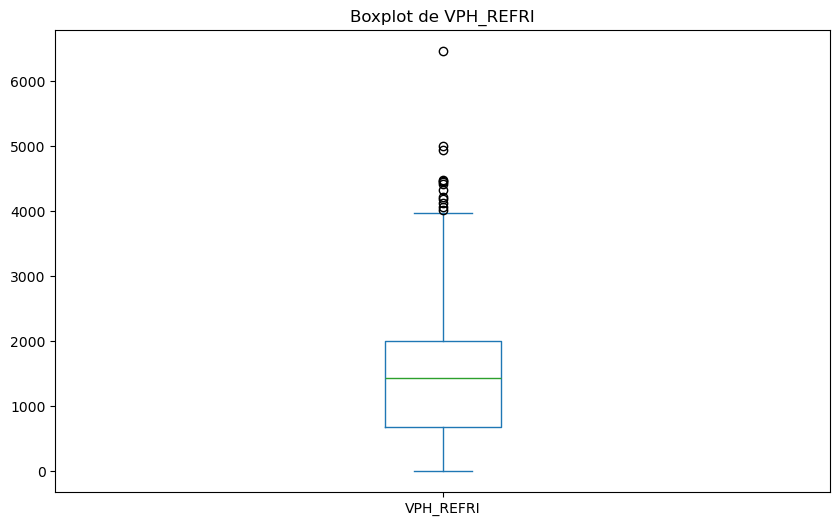

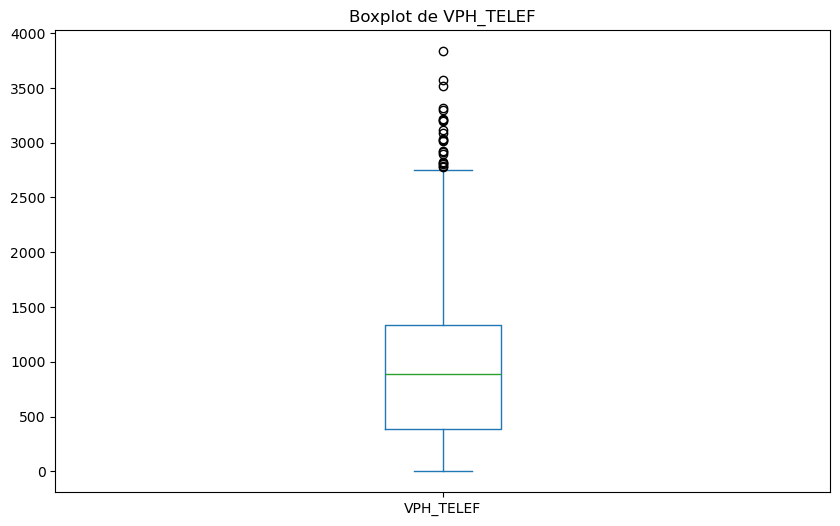

In [218]:
# Seleccionar solo las columnas numéricas del DataFrame censo
censo_numeric = censo_por_AGEB.select_dtypes(include='number')

# Iterar sobre cada columna numérica en el DataFrame censo
for column in censo_numeric.columns:
    # Trazar un boxplot para la columna actual
    plt.figure(figsize=(10, 6))
    censo_numeric[column].plot(kind='box')
    plt.title(f"Boxplot de {column}")
    plt.show()

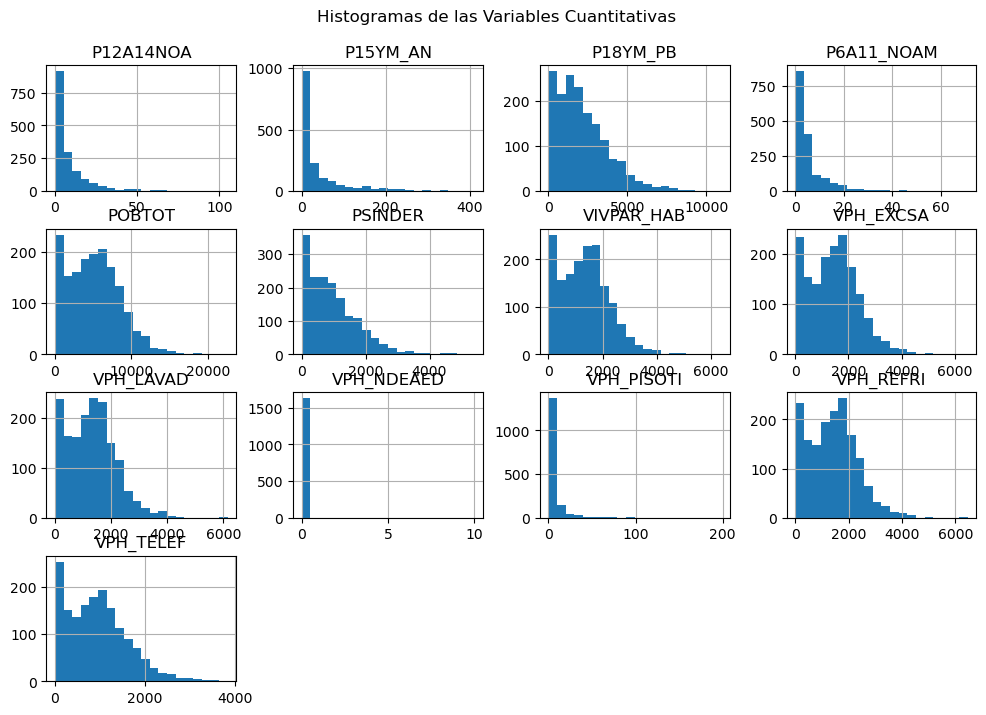

In [219]:
# Análisis de la Distribución de los Datos (Histogramas)
censo_numeric.hist(figsize=(12, 8), bins=20)
plt.suptitle("Histogramas de las Variables Cuantitativas", y=0.95)
plt.show()

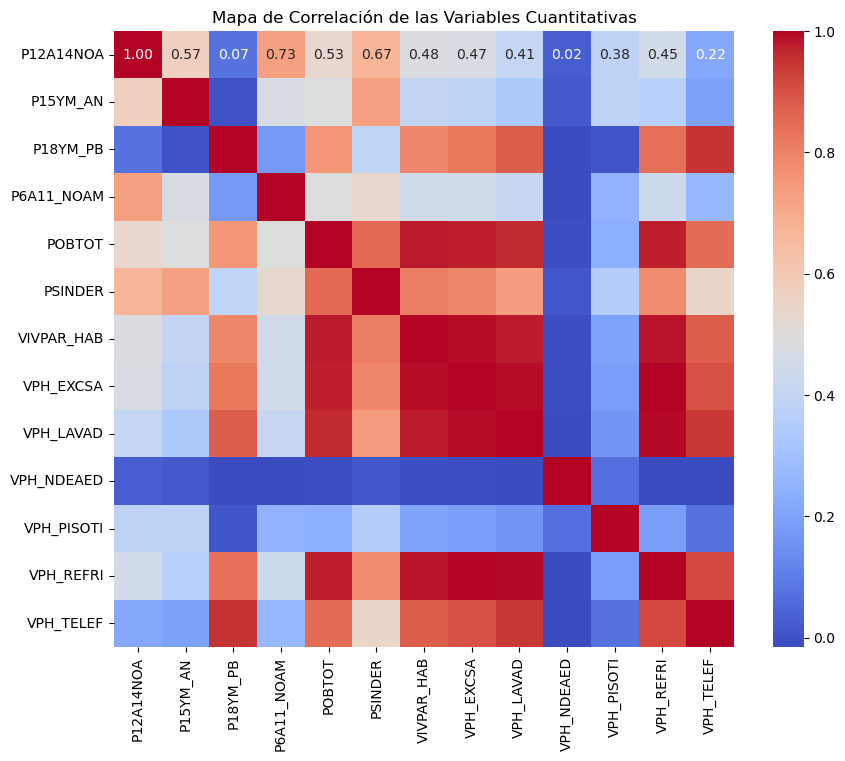

In [220]:


# Calcular la matriz de correlación para las variables cuantitativas
matriz_correlacion = censo_numeric.corr()

# Graficar el mapa de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(matriz_correlacion, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Mapa de Correlación de las Variables Cuantitativas")
plt.show()

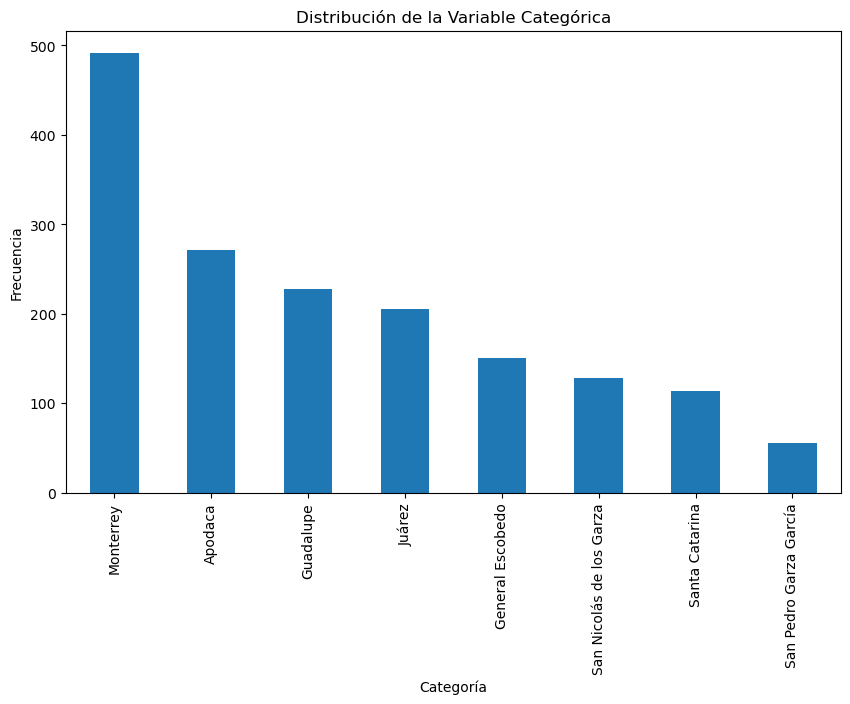

In [173]:
# Distribución de los datos (Diagrama de Barras)
plt.figure(figsize=(10, 6))
censo['NOM_MUN'].value_counts().plot(kind='bar')
plt.title('Distribución de la Variable Categórica')
plt.xlabel('Categoría')
plt.ylabel('Frecuencia')
plt.show()

La frecuencia de cada municipio muestra la cantidad de AGEB's que hay en cada uno de ellos

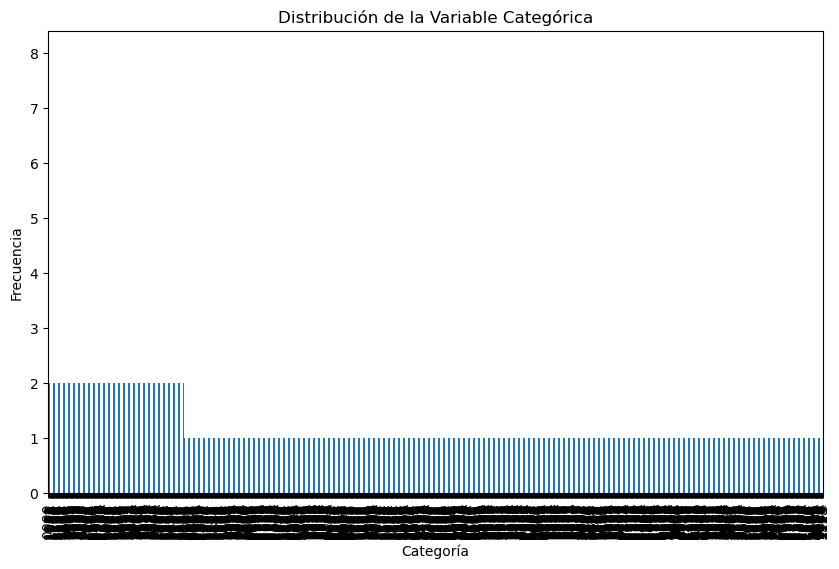

In [174]:
# Distribución de los datos (Diagrama de Barras)
plt.figure(figsize=(10, 6))
censo['AGEB'].value_counts().plot(kind='bar')
plt.title('Distribución de la Variable Categórica')
plt.xlabel('Categoría')
plt.ylabel('Frecuencia')
plt.show()

En este caso, se muestra la razón por la que se hace un código único de AGEB + municipio, dado que, aunque sean pocos los AGEBs repetidos, se debe tener una forma de distinguirse entre ellos

In [175]:
# Tabla de Contingencia
tabla_contingencia = pd.crosstab(censo['AGEB'], censo['NOM_MUN'])
tabla_contingencia

NOM_MUN,Apodaca,General Escobedo,Guadalupe,Juárez,Monterrey,San Nicolás de los Garza,San Pedro Garza García,Santa Catarina
AGEB,,,,,,,,
0000,1,1,1,1,1,1,1,1
0011,0,0,0,0,0,0,1,0
0013,1,0,0,0,0,0,0,1
0014,0,0,0,0,1,0,0,0
0016,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...
5547,0,0,0,0,1,0,0,0
5551,0,0,0,0,1,0,0,0
5566,0,0,0,0,1,0,0,0


**d) Verifica la calidad de los datos: ¿existen valores faltantes, valores incorrectos en los datos, errores de ortografía?**
Sí exsiten valores faltantes, sin embargo, estos fueron reemplazados con 0's para que no hubiera alteración de los datos. Estos 0's no alteran la base de datos dado que el CENSO maneja conteos de diversas características. 

## DENUE

In [176]:
denue.shape

(186665, 43)

In [177]:
denue.columns

Index(['id', 'clee', 'nom_estab', 'raz_social', 'codigo_act', 'nombre_act',
       'per_ocu', 'tipo_vial', 'nom_vial', 'tipo_v_e_1', 'nom_v_e_1',
       'tipo_v_e_2', 'nom_v_e_2', 'tipo_v_e_3', 'nom_v_e_3', 'numero_ext',
       'letra_ext', 'edificio', 'edificio_e', 'numero_int', 'letra_int',
       'tipo_asent', 'nomb_asent', 'tipoCenCom', 'nom_CenCom', 'num_local',
       'cod_postal', 'cve_ent', 'entidad', 'cve_mun', 'municipio', 'cve_loc',
       'localidad', 'ageb', 'manzana', 'telefono', 'correoelec', 'www',
       'tipoUniEco', 'latitud', 'longitud', 'fecha_alta', 'geometry'],
      dtype='object')

In [178]:
denue.cve_mun

0         045
1         031
2         039
3         045
4         026
         ... 
186660    046
186661    006
186662    039
186663    039
186664    039
Name: cve_mun, Length: 186665, dtype: object

El dataframe cargado del DENUE contiene los registros de que cada uno de los negocios del estado de Nuevo León, cotiene 186,665 negocios con 43 columnas con respecto a la localización, tipo, tamño e información general del negocio. Para este proyecto el DENUE se usara para contabilizar el número de restaurantes de cierto tipo en cada AGEB. Para esto se filtro para tener unicamente registros de RESTAURANTES que forman parte del Área Metropolitana de Monterrey.

In [179]:
#Clasificación de Restaurantes
denue[denue['nombre_act'].str.contains('restaurant', case=False, na=False)].nombre_act.unique()


array(['Restaurantes con servicio de preparación de pescados y mariscos',
       'Restaurantes con servicio de preparación de tacos y tortas',
       'Restaurantes de autoservicio',
       'Restaurantes que preparan otro tipo de alimentos para llevar',
       'Restaurantes con servicio de preparación de alimentos a la carta o de comida corrida',
       'Restaurantes con servicio de preparación de antojitos',
       'Restaurantes con servicio de preparación de pizzas, hamburguesas, hot dogs y pollos rostizados para llevar'],
      dtype=object)

In [180]:
#filtro para restaurantes
denue_fil = denue[denue['nombre_act'].str.contains('restaurant', case=False, na=False)]

#filtro por Municipios
#AM = ['Monterrey','San NicolÃ¡s de los Garza','Guadalupe','Apodaca','JuÃ¡rez','Santa Catarina','General Escobedo','San Pedro Garza GarcÃ\xada']

#filtrar por clave de  municipios (['Monterrey','San NicolÃ¡s de los Garza','Guadalupe','Apodaca','JuÃ¡rez','Santa Catarina','General Escobedo','San Pedro Garza GarcÃ\xada']
mun_c = ['039','046','026','006','031','048','021','019']
denue_fil= denue_fil[denue_fil['cve_mun'].isin(mun_c)]


In [181]:
#agrego una columna de identificación compuesta por el número de MUNICIPIO y AGEB
denue_fil['CVEMA'] = denue_fil['cve_mun'].map(str).str.zfill(3) + denue_fil['ageb'].map(str).str.zfill(4)

In [182]:
denue_fil.columns

Index(['id', 'clee', 'nom_estab', 'raz_social', 'codigo_act', 'nombre_act',
       'per_ocu', 'tipo_vial', 'nom_vial', 'tipo_v_e_1', 'nom_v_e_1',
       'tipo_v_e_2', 'nom_v_e_2', 'tipo_v_e_3', 'nom_v_e_3', 'numero_ext',
       'letra_ext', 'edificio', 'edificio_e', 'numero_int', 'letra_int',
       'tipo_asent', 'nomb_asent', 'tipoCenCom', 'nom_CenCom', 'num_local',
       'cod_postal', 'cve_ent', 'entidad', 'cve_mun', 'municipio', 'cve_loc',
       'localidad', 'ageb', 'manzana', 'telefono', 'correoelec', 'www',
       'tipoUniEco', 'latitud', 'longitud', 'fecha_alta', 'geometry', 'CVEMA'],
      dtype='object')

In [183]:
denue_fil

,id,clee,nom_estab,raz_social,codigo_act,nombre_act,per_ocu,tipo_vial,nom_vial,tipo_v_e_1,...,manzana,telefono,correoelec,www,tipoUniEco,latitud,longitud,fecha_alta,geometry,CVEMA
130020,3013745,19048722219001672000000000U6,BAR LAS PALAPAS,None,722512,Restaurantes con servicio de preparación de pe...,6 a 10 personas,CALLE,MIGUEL HIDALGO Y COSTILLA,CALLE,...,010,8124141290,None,None,Fijo,25.667727,-100.430123,2010-07,POINT (-100.43012 25.66773),0480564
130027,6217417,19039722514007081000000000U7,LA SIBERIA,None,722514,Restaurantes con servicio de preparación de ta...,0 a 5 personas,CALLE,CAPRICORNIO,PRIVADA,...,001,8181030601,None,None,Fijo,25.637474,-100.283295,2010-07,POINT (-100.28330 25.63747),0392190
130029,2950978,19021722516000031000000000U2,LA SIBERIA,None,722516,Restaurantes de autoservicio,0 a 5 personas,AVENIDA,AVENIDA DE LA INDUSTRIA,CALLE,...,003,8184523290,INGIBAGO@GIBAGO.COM,None,Fijo,25.806453,-100.349648,2014-12,POINT (-100.34965 25.80645),0210772
130031,3034318,19039722219008231010000000U3,LA SIBERIA,None,722516,Restaurantes de autoservicio,0 a 5 personas,CALLE,AYUTLA,CALLE,...,020,8110656582,ROCIOCARRALES_@HOTMAIL.COM,None,Fijo,25.660972,-100.302619,2010-07,POINT (-100.30262 25.66097),0391915
130037,2972518,19039722511003101000000000U3,LA SIBERIA,None,722511,Restaurantes con servicio de preparación de al...,0 a 5 personas,AVENIDA,ANTONIO I. VILLARREAL,CALLE,...,032,8181919473,None,None,Fijo,25.687682,-100.277631,2014-12,POINT (-100.27763 25.68768),0391351
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159727,7787560,19039722514018231000000000U5,TAQUERIA RENDILES,None,722514,Restaurantes con servicio de preparación de ta...,0 a 5 personas,ANDADOR,ALFONSO DOMENE,CALLE,...,001,None,None,None,Fijo,25.725104,-100.343627,2019-11,POINT (-100.34363 25.72510),0390527
159728,2957676,19048722514000961000000000U8,TAQUERIA REYES,None,722514,Restaurantes con servicio de preparación de ta...,0 a 5 personas,AVENIDA,PERIMETRAL SUR,CALLE,...,009,8334492272,None,None,Semifijo,25.689394,-100.447467,2014-12,POINT (-100.44747 25.68939),0480808
159729,6216467,19048722219000901010000000U0,TAQUERIA REYES,None,722514,Restaurantes con servicio de preparación de ta...,0 a 5 personas,CALLE,SAN PEDRO EL ALTO,CALLE,...,019,8111787543,None,None,Semifijo,25.696992,-100.463034,2010-07,POINT (-100.46303 25.69699),0481238
159741,2993149,19019722514000501010000000U3,TAQUERIA REYES TIPO SIBERIA,None,722513,Restaurantes con servicio de preparación de an...,0 a 5 personas,CALLE,LICENCIADO BENITO JUAREZ,AVENIDA,...,017,None,None,None,Semifijo,25.662323,-100.403612,2014-12,POINT (-100.40361 25.66232),0190115


In [184]:
# Creo un dataframes con frecuencias de restuarantes en cada AGEB
my_pivot=pd.pivot_table(denue_fil,index=['CVEMA', 'nombre_act'],values=['codigo_act'],aggfunc=['count'])
my_pivot

count
                                                           codigo_act
CVEMA   nombre_act                                                   
0060051 Restaurantes con servicio de preparación de piz...          1
        Restaurantes con servicio de preparación de tac...          2
0060066 Restaurantes con servicio de preparación de ali...          1
        Restaurantes con servicio de preparación de ant...          5
        Restaurantes con servicio de preparación de pes...          1
...                                                               ...
0481581 Restaurantes con servicio de preparación de piz...          1
0481609 Restaurantes con servicio de preparación de tac...          2
0481628 Restaurantes que preparan otro tipo de alimento...          1
0481702 Restaurantes con servicio de preparación de ali...          2
        Restaurantes con servicio de preparación de tac...          2

[4669 rows x 1 columns]

In [185]:
# Creamos un DataFrame con los índices y columnas deseados
result = my_pivot['count']['codigo_act'].unstack(fill_value=0)

# Reiniciamos los índices para tener 'Clave_AGEB' como una columna
result = result.reset_index()

# Renombramos las columnas
result.columns.name = None  # Eliminamos el nombre de las columnas
result.columns = ['CVEMA'] + [f'Restaurante_{col}' for col in result.columns[1:]]

# Mostramos el resultado
result

,CVEMA,Restaurante_Restaurantes con servicio de preparación de alimentos a la carta o de comida corrida,Restaurante_Restaurantes con servicio de preparación de antojitos,Restaurante_Restaurantes con servicio de preparación de pescados y mariscos,"Restaurante_Restaurantes con servicio de preparación de pizzas, hamburguesas, hot dogs y pollos rostizados para llevar",Restaurante_Restaurantes con servicio de preparación de tacos y tortas,Restaurante_Restaurantes de autoservicio,Restaurante_Restaurantes que preparan otro tipo de alimentos para llevar
0,0060051,0,0,0,1,2,0,0
1,0060066,1,5,1,3,8,2,0
2,0060070,5,2,2,1,8,3,0
3,0060085,7,2,2,3,9,1,0
4,006009A,9,3,0,2,10,1,2
...,...,...,...,...,...,...,...,...
1288,0481562,0,0,0,0,1,0,0
1289,0481581,0,0,0,1,0,0,0
1290,0481609,0,0,0,0,2,0,0
1291,0481628,0,0,0,0,0,0,1


In [186]:
freq_rest = result.copy()

In [187]:
freq_rest.head()

,CVEMA,Restaurante_Restaurantes con servicio de preparación de alimentos a la carta o de comida corrida,Restaurante_Restaurantes con servicio de preparación de antojitos,Restaurante_Restaurantes con servicio de preparación de pescados y mariscos,"Restaurante_Restaurantes con servicio de preparación de pizzas, hamburguesas, hot dogs y pollos rostizados para llevar",Restaurante_Restaurantes con servicio de preparación de tacos y tortas,Restaurante_Restaurantes de autoservicio,Restaurante_Restaurantes que preparan otro tipo de alimentos para llevar
0,0060051,0,0,0,1,2,0,0
1,0060066,1,5,1,3,8,2,0
2,0060070,5,2,2,1,8,3,0
3,0060085,7,2,2,3,9,1,0
4,006009A,9,3,0,2,10,1,2


In [188]:
freq_rest.to_csv('freq_rest.csv')

### EDA

1) **Calcula medidas estadísticas**

   **Variables cuantitativas**

   - **Medidas de tendencia central:** Promedio, media, mediana y moda de los datos.
   - **Medidas de dispersión:** Rango (máximo - mínimo), varianza, desviación estándar.

   **Variables cualitativas o categóricas**

   - Tabla de distribución de frecuencia.
   - Moda.

2) **Explora los datos usando herramientas de visualización**

   **Variables cuantitativas:**

   - Medidas de posición no-central: Cuartiles, valores atípicos (outliers), boxplots.
   - Análisis de distribución de los datos (Histogramas). Identificar si tienen forma simétrica o asimétrica.
   - Análisis de correlación de los datos, mapa de calor.

   **Variables cualitativas o categóricas:**

   - Distribución de los datos (Diagramas de barras, diagramas de pastel).
   - Encontrar relaciones entre variables, principalmente con lo que se quiere predecir, para ver cómo se comporta. Pueden crear tablas de contingencia usando la función de pandas `crosstab` o también usar la función chi-cuadrado.

**Material de apoyo:**
[Measure the correlation between numerical and categorical variables and the correlation between two categorical variables in Python: Chi-square and ANOVA](http://www.sefidian.com/2022/08/02/measure-the-correlation-between-numerical-and-categorical-variables-and-the-correlation-between-two-categorical-variables-in-python-chi-square-and-anova/)

In [189]:
freq_rest.describe()

,Restaurante_Restaurantes con servicio de preparación de alimentos a la carta o de comida corrida,Restaurante_Restaurantes con servicio de preparación de antojitos,Restaurante_Restaurantes con servicio de preparación de pescados y mariscos,"Restaurante_Restaurantes con servicio de preparación de pizzas, hamburguesas, hot dogs y pollos rostizados para llevar",Restaurante_Restaurantes con servicio de preparación de tacos y tortas,Restaurante_Restaurantes de autoservicio,Restaurante_Restaurantes que preparan otro tipo de alimentos para llevar
count,1293.000000,1293.000000,1293.000000,1293.000000,1293.000000,1293.000000,1293.000000
mean,1.712297,1.486466,0.438515,1.978345,3.846868,0.543697,0.574633
std,4.141739,1.683330,0.879928,2.004135,3.756695,1.407845,1.279164
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,1.000000,3.000000,0.000000,0.000000
75%,2.000000,2.000000,1.000000,3.000000,5.000000,1.000000,1.000000
max,62.000000,14.000000,12.000000,14.000000,35.000000,15.000000,30.000000


In [190]:
freq_rest.describe(include='O')

,CVEMA
count,1293
unique,1293
top,0060051
freq,1


Con lo anterior se asegura que existe un código único para cada AGEB ya que no se repite ningún dato

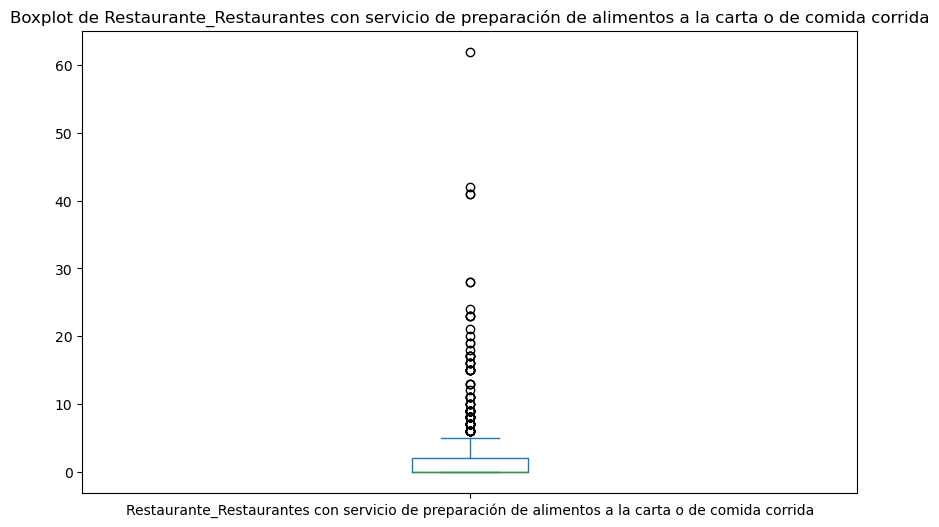

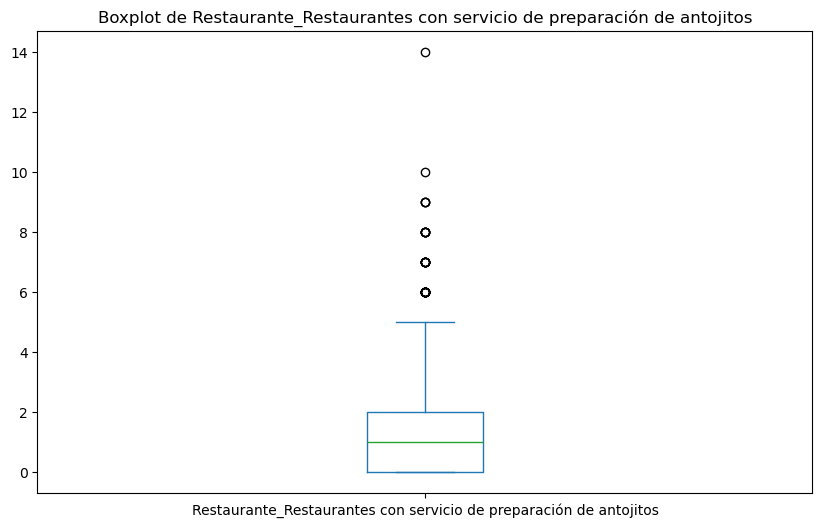

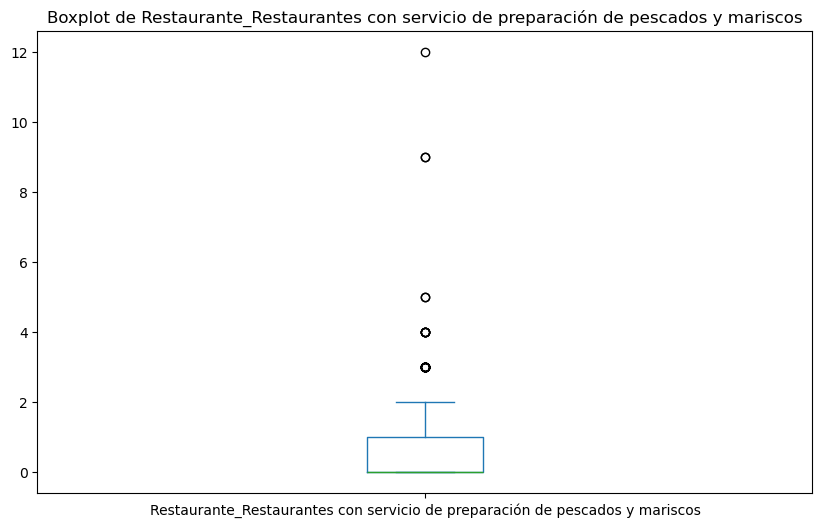

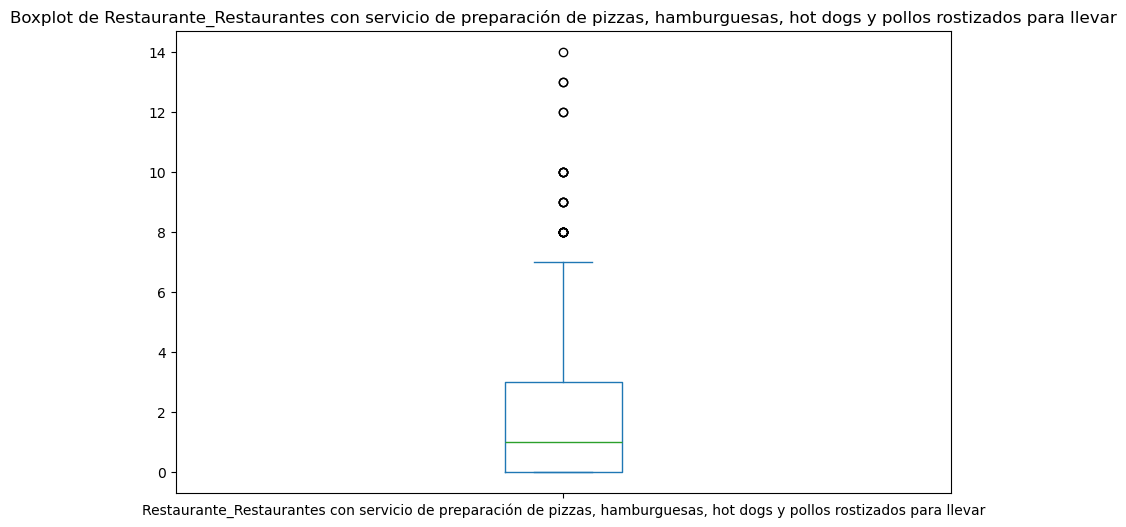

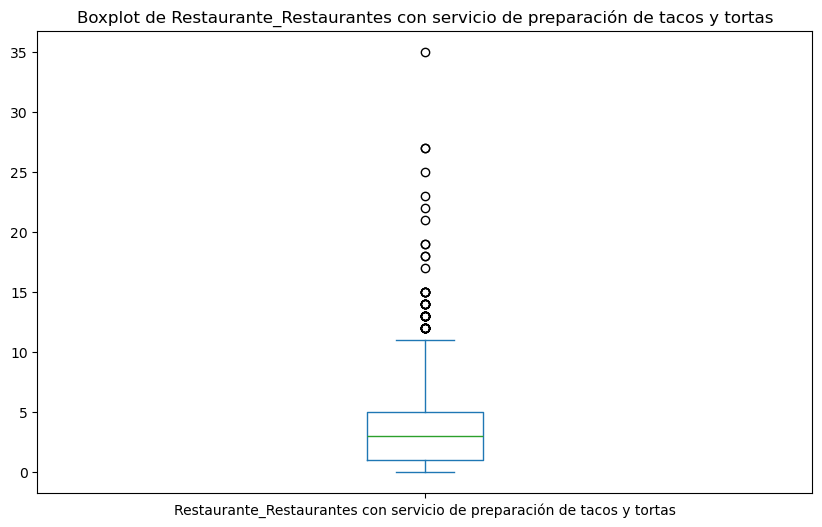

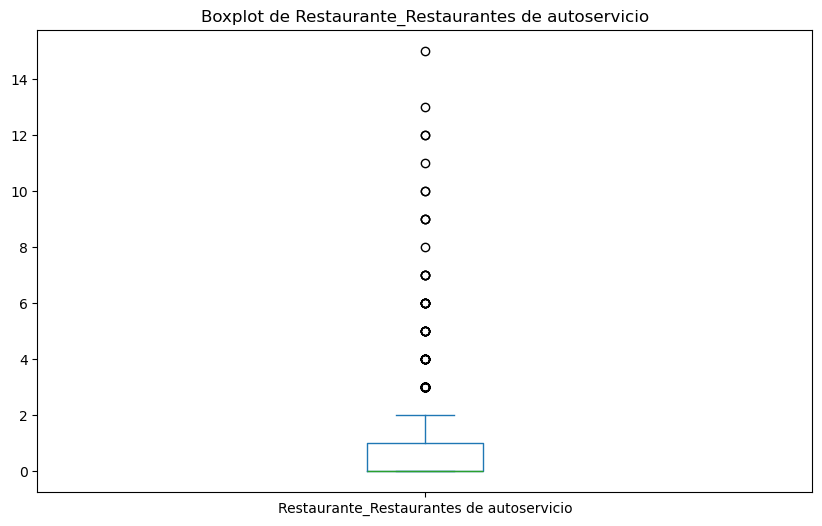

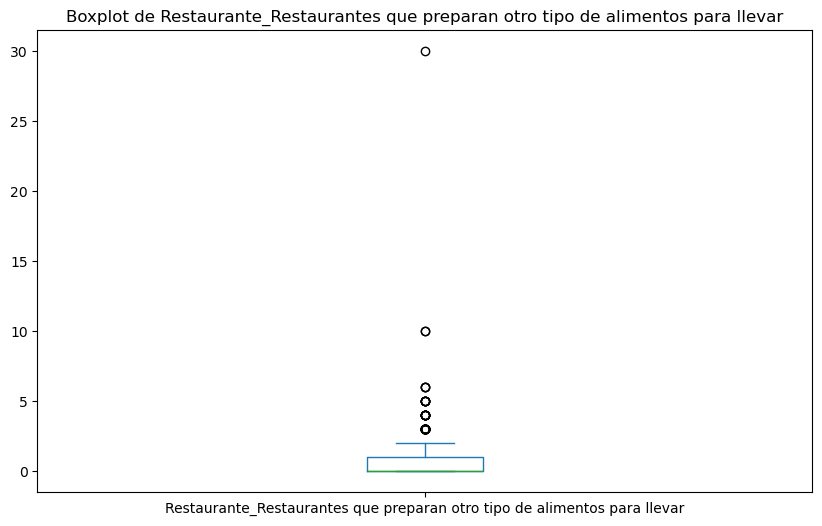

In [191]:
# Seleccionar solo las columnas numéricas del DataFrame censo
freq_rest_numeric = freq_rest.select_dtypes(include='number')

# Iterar sobre cada columna numérica en el DataFrame censo
for column in freq_rest_numeric.columns:
    # Trazar un boxplot para la columna actual
    plt.figure(figsize=(10, 6))
    freq_rest[column].plot(kind='box')
    plt.title(f"Boxplot de {column}")
    plt.show()

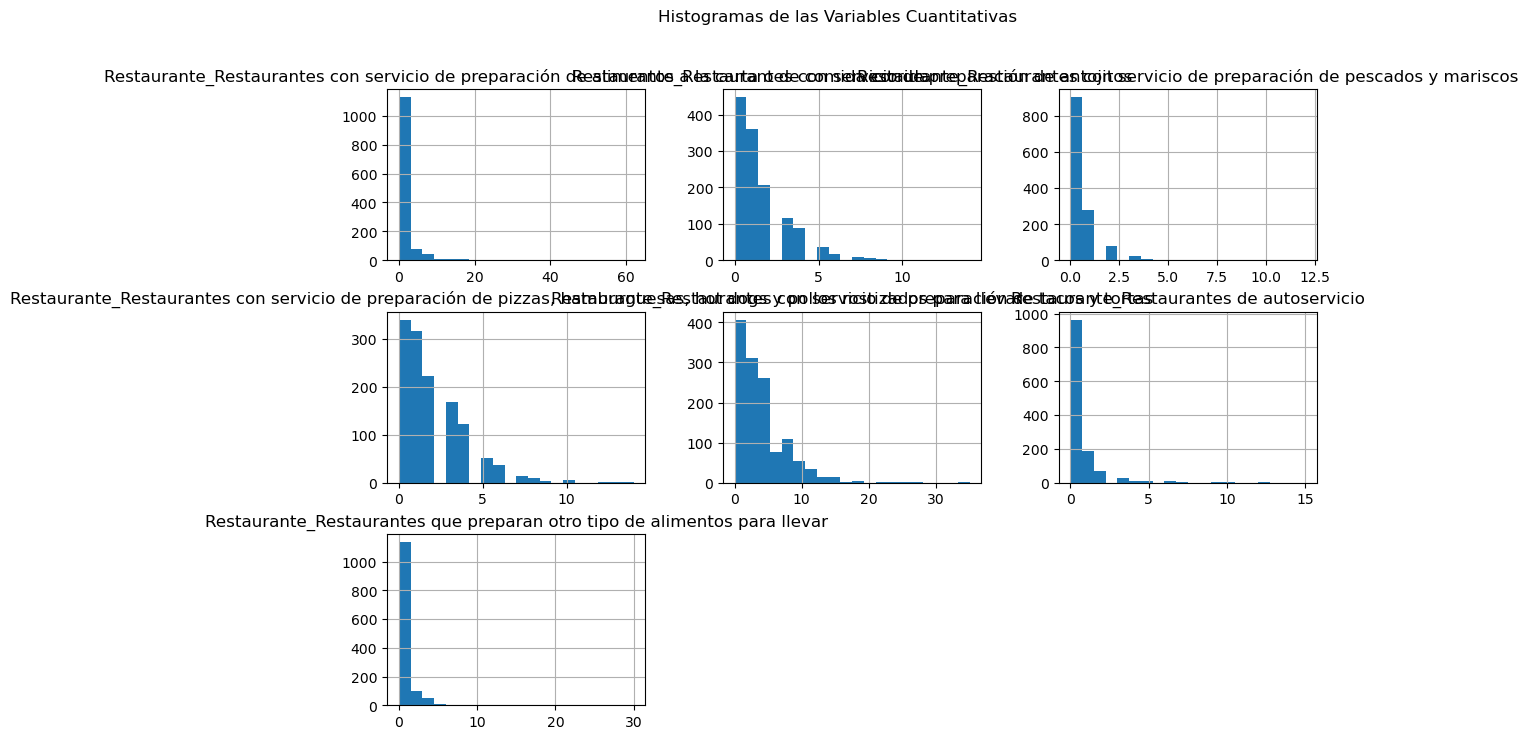

In [192]:
# Análisis de la Distribución de los Datos (Histogramas)
freq_rest.hist(figsize=(12, 8), bins=20)
plt.suptitle("Histogramas de las Variables Cuantitativas")
plt.show()

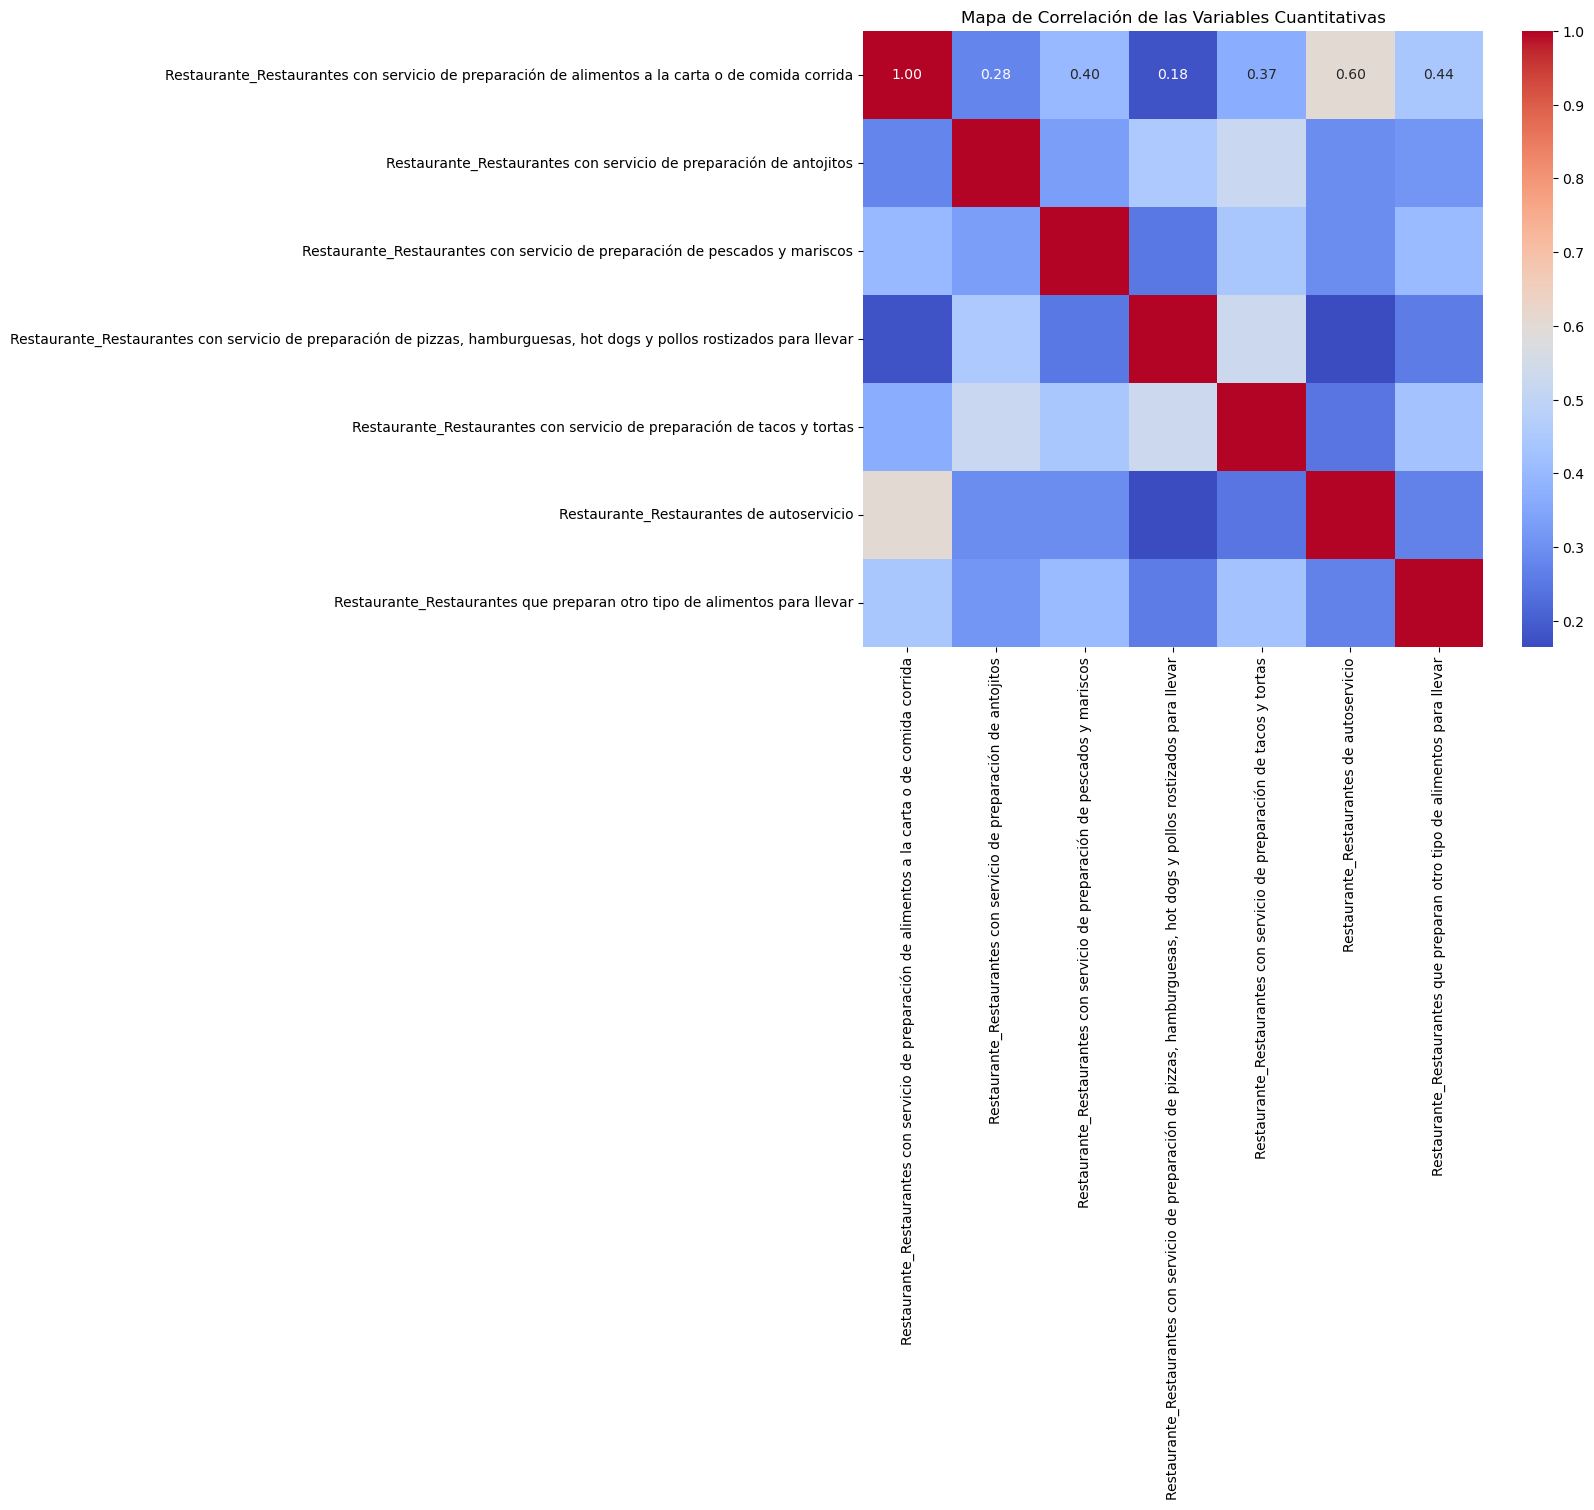

In [193]:
# Calcular la matriz de correlación para las variables cuantitativas
matriz_correlacion = freq_rest_numeric.corr()

# Graficar el mapa de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(matriz_correlacion, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Mapa de Correlación de las Variables Cuantitativas")
plt.show()

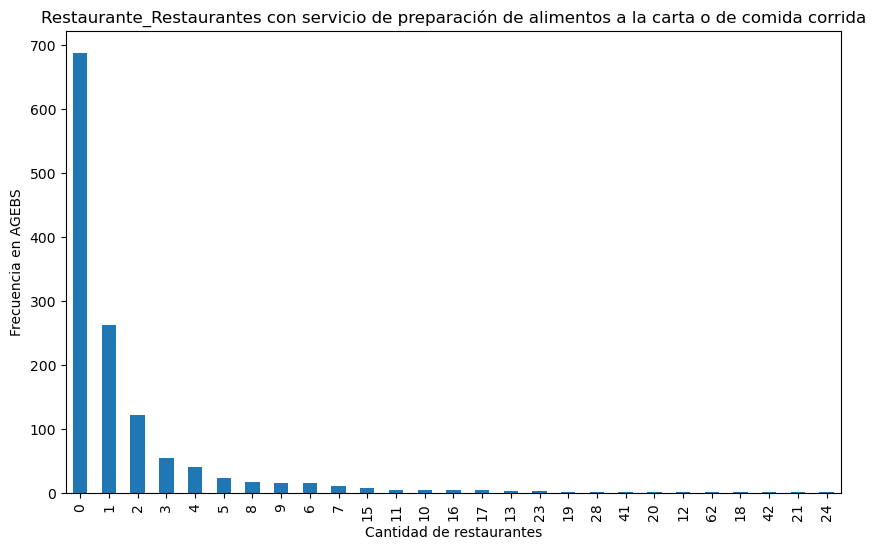

In [194]:
plt.figure(figsize =(10,6))
freq_rest['Restaurante_Restaurantes con servicio de preparación de alimentos a la carta o de comida corrida'].value_counts().plot(kind='bar')
plt.title('Restaurante_Restaurantes con servicio de preparación de alimentos a la carta o de comida corrida')
plt.xlabel('Cantidad de restaurantes')
plt.ylabel('Frecuencia en AGEBS')
plt.show()

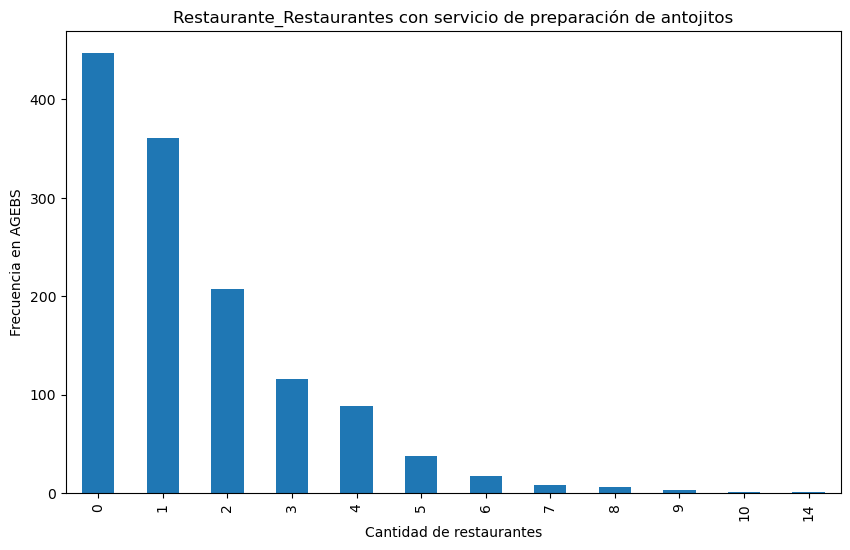

In [195]:
plt.figure(figsize =(10,6))
freq_rest['Restaurante_Restaurantes con servicio de preparación de antojitos'].value_counts().plot(kind='bar')
plt.title('Restaurante_Restaurantes con servicio de preparación de antojitos')
plt.xlabel('Cantidad de restaurantes')
plt.ylabel('Frecuencia en AGEBS')
plt.show()

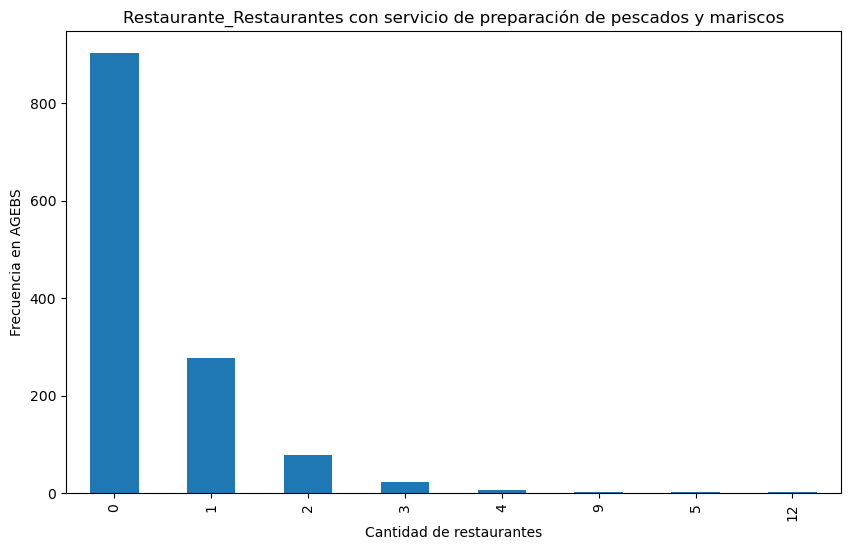

In [196]:
plt.figure(figsize =(10,6))
freq_rest['Restaurante_Restaurantes con servicio de preparación de pescados y mariscos'].value_counts().plot(kind='bar')
plt.title('Restaurante_Restaurantes con servicio de preparación de pescados y mariscos')
plt.xlabel('Cantidad de restaurantes')
plt.ylabel('Frecuencia en AGEBS')
plt.show()

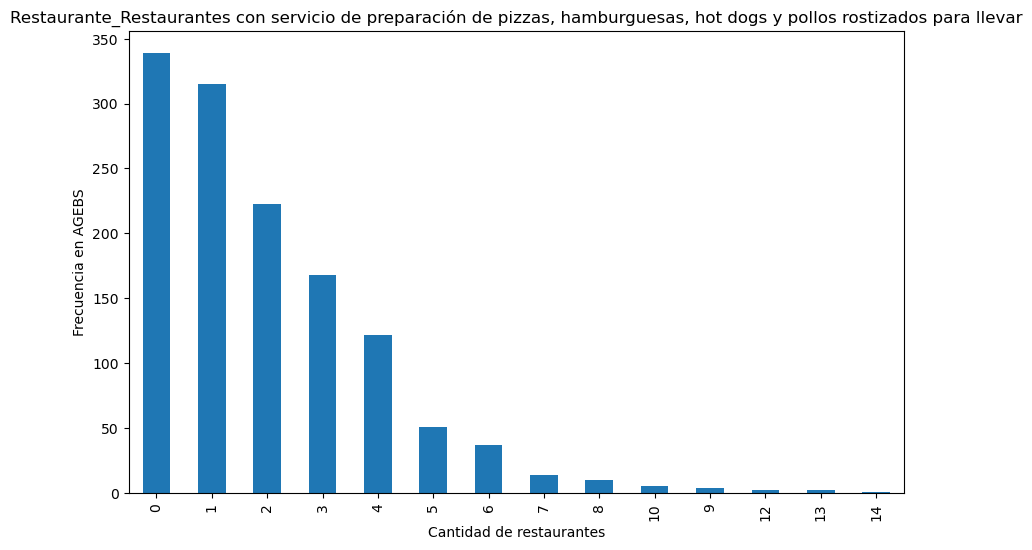

In [197]:
plt.figure(figsize =(10,6))
freq_rest['Restaurante_Restaurantes con servicio de preparación de pizzas, hamburguesas, hot dogs y pollos rostizados para llevar'].value_counts().plot(kind='bar')
plt.title('Restaurante_Restaurantes con servicio de preparación de pizzas, hamburguesas, hot dogs y pollos rostizados para llevar')
plt.xlabel('Cantidad de restaurantes')
plt.ylabel('Frecuencia en AGEBS')
plt.show()

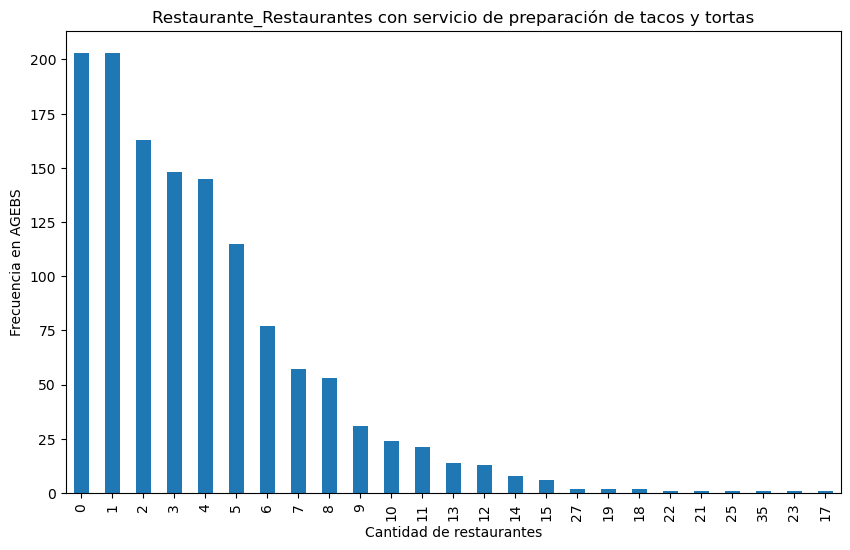

In [198]:
plt.figure(figsize =(10,6))
freq_rest['Restaurante_Restaurantes con servicio de preparación de tacos y tortas'].value_counts().plot(kind='bar')
plt.title('Restaurante_Restaurantes con servicio de preparación de tacos y tortas')
plt.xlabel('Cantidad de restaurantes')
plt.ylabel('Frecuencia en AGEBS')
plt.show()

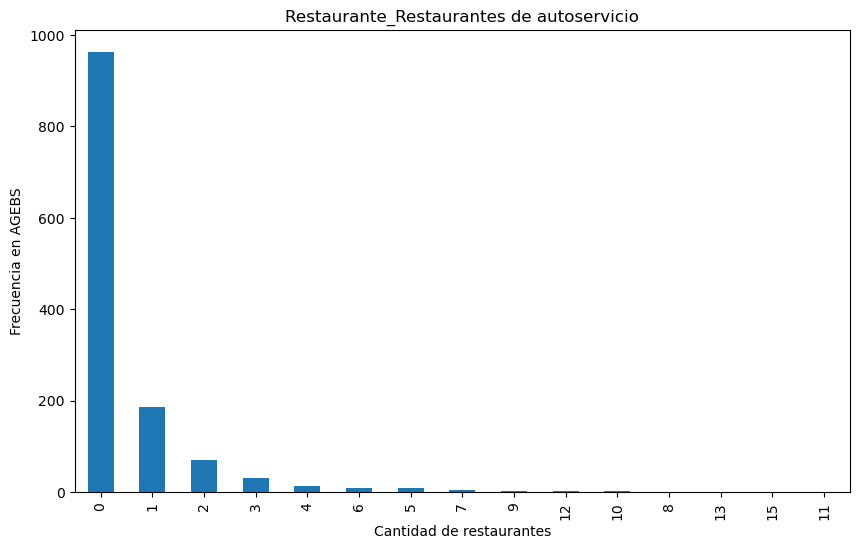

In [199]:
plt.figure(figsize =(10,6))
freq_rest['Restaurante_Restaurantes de autoservicio'].value_counts().plot(kind='bar')
plt.title('Restaurante_Restaurantes de autoservicio')
plt.xlabel('Cantidad de restaurantes')
plt.ylabel('Frecuencia en AGEBS')
plt.show()

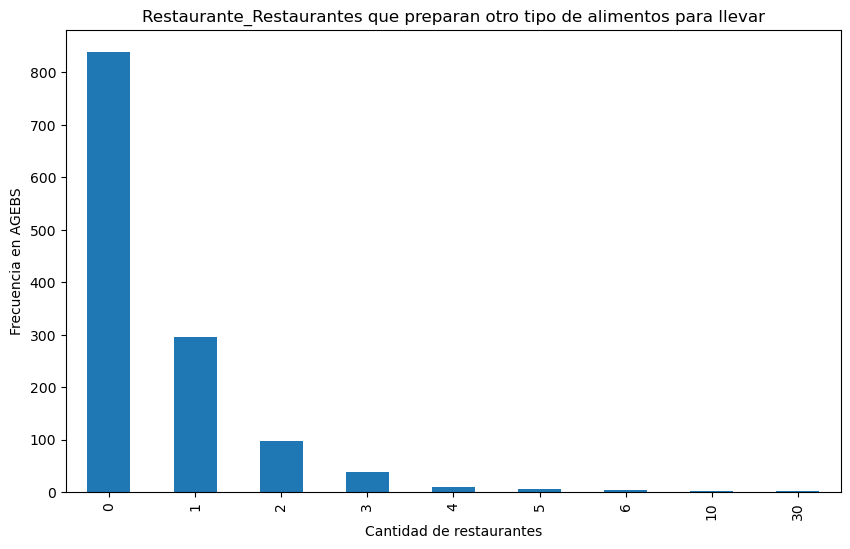

In [200]:
plt.figure(figsize =(10,6))
freq_rest['Restaurante_Restaurantes que preparan otro tipo de alimentos para llevar'].value_counts().plot(kind='bar')
plt.title('Restaurante_Restaurantes que preparan otro tipo de alimentos para llevar')
plt.xlabel('Cantidad de restaurantes')
plt.ylabel('Frecuencia en AGEBS')
plt.show()

En general, en cada tipo de restaurante predomina el conteo de 0, esto se debe a que de todos los AGEBs a usar, la mayoría de ellos no contienen todos los tipos de restaurantes, e incluso puede que haya AGEB's sin ningún tipo de restaurante

**d) Verifica la calidad de los datos: ¿existen valores faltantes, valores incorrectos en los datos, errores de ortografía?**
Para el uso de esta base de datos que contiene el conteo de los tipos de restaurantes en cada AGEB, la existencia de valores faltantes es nula dado que, la columna en la que se basa este nuevo archivo, nombre_act, no contenía ningún valor nulo.